简答题：
1. 如果你的训练集具有数百万个特征，那么可以使用哪种线性回归训练算法？

    - 随机梯度下降

2. 如果你的训练集里特征的数值大小迥异，那么哪些算法可能会受到影响？受影响程度如何？你应该怎么做？

- 基于距离的算法：K临近knn,支持向量机SVM
- 基于梯度下降的算法：线性回归
- 正则化模型：岭回归ridge，套索回归lasso

3. 训练逻辑回归模型时，梯度下降可能会卡在局部最小值中吗？

- 不会，使用随机梯度下降会跳出局部最小值，使用批量梯度下降可以采用学习率衰减的方法

4. 如果你让它们运行足够长的时间，是否所有的梯度下降算法都能得出相同的模型？

- 不是，随机梯度下降会在最优的范围徘徊
    批量梯度下降最终的收敛点由学习率决定

5. 假设你使用批量梯度下降，并在每个轮次绘制验证误差。如果你发现验证错误持续上升，那么可能是什么情况？你该如何解决？

- 可能是学习率过大，导致跳过了收敛点，需要调小学习率或者采用早停

6. 当验证误差上升时立即停止小批量梯度下降是个好主意吗？

- 不是，因为可能是局部上升的暂时的现象

7. 哪种梯度下降算法（在我们讨论过的算法中）将最快地到达最佳解附近？哪个实际上会收敛？如何使其他的也收敛

- 随机梯度下降
- 批量梯度下降实际上会收敛

8. 假设你正在使用多项式回归。绘制学习曲线后，你会发现训练误差和验证误差之间存在很大的差距。发生了什么？解决此问题的三种方法是什么？

- 过拟合现象
- 减少特征，增加正杂化，增加数据

9. 假设你正在使用岭回归，并且你注意到训练误差和验证误差几乎相等且相当高。你是否会说模型存在高偏差或高方差？你应该增加正则化超参数α还是减小它呢？

- 高偏差，欠拟合
- 减小α

10. 为什么要使用：a.岭回归而不是简单的线性回归（即没有任何正则化）？b.Lasso而不是岭回归？c.弹性网络而不是Lasso回归？

- a.防止过拟合，
- b.合适稀疏特征场景
- c.弹性网络处理搞相关特征较好，在特征数>样本数的时候更稳定

11. 假设你要将图片分类为室外/室内和白天/夜间。你应该实现两个逻辑回归分类器还是一个softmax回归分类器？
- 两个逻辑回归分类
- 因为是两个独立任务，可能同时出现室内+白天的情况，而softmax回归是互斥分类，不能两个同时出现

In [69]:
import numpy as np
from copy import deepcopy

from scipy.stats import alpha
from sklearn.datasets import load_iris

# todo 编程题: 在不使用sklearn的情况下，仅使用Numpy，为softmax回归实现带早停的批量梯度下降，将它用于分类任务，
#  例如鸢尾花数据集  load_iris, 只用两个特征就可以："petal width (cm)", "petal length (cm)"
#  强调：除了读数据，其他全用numpy （包括分离测试+验证），不用sklearn
iris = load_iris(as_frame=True)
X = iris.data[["petal width (cm)", "petal length (cm)"]]
y = iris.target

# 分离测试集和验证集
def my_separate(X, y, ratio):
    shuffle_index = np.random.permutation(len(y))
    test_index = shuffle_index[:int(len(y) * ratio)]
    train_index = shuffle_index[int(len(y) * ratio):]
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = my_separate(X, y, 0.2)

#  注意：
#  1. 要实现l2正则化
#  2. 除了数据读取，其他仅使用numpy，包括训练集+验证集分离，以及softmax预测 和 损失计算

In [139]:
class My_Softmax:
    def __init__(self,max_iter = 100,tol =1e-4,alpha = 0.01,learning_rate = 0.01):
        self.w = None
        self.b = None
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.classes_ = None
    def _softmax(self,X):
        e_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        return e_X / np.sum(e_X, axis=1, keepdims=True)
    def _onehot(self,y):
        return np.eye(len(self.classes_))[y]
    def fit(self,X,y):

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        # 初始化
        self.w = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)

        y_onehot = self._onehot(y)
        n = X.shape[0]
        prev_loss = np.inf
        for i in range(self.max_iter):
            # 每一行对应一个样本在所有类别上的分数
            score = np.dot( X,self.w ) + self.b
            # 可能发生指数爆炸的情况
            p = self._softmax(score)
            # 定义损失函数交叉熵损失 + L2正杂化
            epsilon = 1e-12  # 避免 log(0) 的情况
            loss = -np.mean(np.sum(y_onehot * np.log(p+epsilon), axis=1)) + (self.alpha/2) * np.sum(self.w **2 )
            if np.abs(prev_loss - loss) < self.tol:
                print(f"早停于第 {i}次迭代")
                break
            prev_loss = loss
            # 先计算梯度
            loss_w = np.dot(X.T,(p-y_onehot))/n + self.alpha * self.w
            loss_b = np.mean(p-y_onehot,axis=0)
            # 更新梯度
            self.w = self.w - self.learning_rate * loss_w
            self.b = self.b - self.learning_rate * loss_b
            print(f"迭代 {i}, 损失: {loss}")
    def predict_proba(self,X):
        score = np.dot(X,self.w ) + self.b
        return self._softmax(score)

    def predict(self,X):
        p = self.predict_proba(X)
        return np.argmax(p,axis=1)



In [153]:
s = My_Softmax(alpha=0.1,max_iter=10000,learning_rate=0.1)
s.fit(X_train,y_train)
y_p = s.predict(X_test)

迭代 0, 损失: 1.0946128767688938
迭代 1, 损失: 1.0094460315044114
迭代 2, 损失: 0.9919559147252984
迭代 3, 损失: 0.9831855030625422
迭代 4, 损失: 0.9767416142773099
迭代 5, 损失: 0.9711568158864932
迭代 6, 损失: 0.9659506198544558
迭代 7, 损失: 0.9609432143229111
迭代 8, 损失: 0.956061821457081
迭代 9, 损失: 0.951275226279684
迭代 10, 损失: 0.9465692883325292
迭代 11, 损失: 0.9419371517652575
迭代 12, 损失: 0.937375151686779
迭代 13, 损失: 0.9328810491071512
迭代 14, 损失: 0.9284532536745026
迭代 15, 损失: 0.9240904763856238
迭代 16, 损失: 0.9197915728648489
迭代 17, 损失: 0.9155554721740145
迭代 18, 损失: 0.9113811443427876
迭代 19, 损失: 0.9072675855255332
迭代 20, 损失: 0.9032138112058248
迭代 21, 损失: 0.8992188530765047
迭代 22, 损失: 0.8952817575940443
迭代 23, 损失: 0.8914015852905609
迭代 24, 损失: 0.8875774104244125
迭代 25, 损失: 0.8838083207787409
迭代 26, 损失: 0.8800934175220764
迭代 27, 损失: 0.8764318150929509
迭代 28, 损失: 0.8728226410921345
迭代 29, 损失: 0.8692650361757842
迭代 30, 损失: 0.8657581539470163
迭代 31, 损失: 0.8623011608451848
迭代 32, 损失: 0.8588932360328259
迭代 33, 损失: 0.8555335712

In [155]:
s.w

array([[-0.41097952, -0.10515566,  0.51607399],
       [-0.79939813,  0.24639883,  0.55297274]])

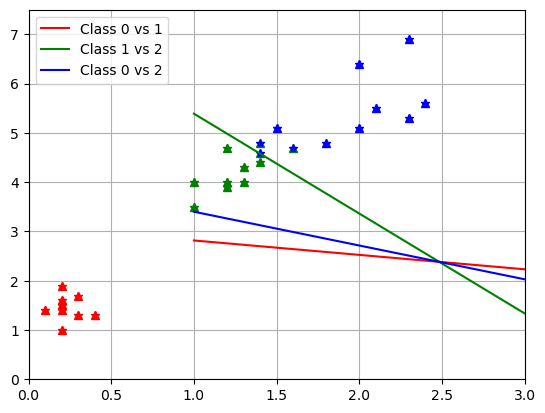

In [170]:


import matplotlib.pyplot as plt
mask0 = (y[X_test.index] == 0).values
mask1 = (y[X_test.index] == 1).values
mask2 = (y[X_test.index] == 2).values
plt.plot(X_test.loc[mask0, X_test.columns[0]],
         X_test.loc[mask0, X_test.columns[1]],
         "r^")
plt.plot(X_test.loc[mask1, X_test.columns[0]],
         X_test.loc[mask1, X_test.columns[1]],
         "g^")
plt.plot(X_test.loc[mask2, X_test.columns[0]],
         X_test.loc[mask2, X_test.columns[1]],
         "b^")
mask0 = (y_p == 0)
mask1 = (y_p == 1)
mask2 = (y_p == 2)
plt.plot(X_test.loc[mask0, X_test.columns[0]],
         X_test.loc[mask0, X_test.columns[1]],
         "r*")
plt.plot(X_test.loc[mask1, X_test.columns[0]],
         X_test.loc[mask1, X_test.columns[1]],
         "g*")
plt.plot(X_test.loc[mask2, X_test.columns[0]],
         X_test.loc[mask2, X_test.columns[1]],
         "b*")
x= np.linspace(1,7,100)
w0 , w1 ,w2 = s.w[:,0], s.w[:,1], s.w[:,2]
b0,b1,b2 = s.b[0], s.b[1], s.b[2]
# 计算三条决策边界线（修正后的公式）
# 注意：这里计算的是两类之间的决策边界，不是单类的边界
plt.plot(x, -( (b0-b1) + (w0[0]-w1[0])*x ) / (w0[1]-w1[1]), 'r-', label='Class 0 vs 1')  # 类0和类1的分界线
plt.plot(x, -( (b1-b2) + (w1[0]-w2[0])*x ) / (w1[1]-w2[1]), 'g-', label='Class 1 vs 2')  # 类1和类2的分界线
plt.plot(x, -( (b0-b2) + (w0[0]-w2[0])*x ) / (w0[1]-w2[1]), 'b-', label='Class 0 vs 2')  # 类0和类2的分界线

plt.grid(True)
plt.legend()
plt.axis((0,3,0,7.5))
plt.show()
